In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

First, I import the data as pandas data frames and format the row/coumn labels. I use multi indexing for the column names (metric, year the metric was recorded). Rows are indexed by the firm number.

I also convert the pandas data frames to numpy arrays for ease of manipulating the data sets (to do things I can not do with pandas).

In [2]:
data_s0 = pd.read_excel('Data for technical assessment.xlsx', header=[0,1], index_col=0, sheet_name=0)
data_s1 = pd.read_excel('Data for technical assessment.xlsx', header=[0,1], index_col=0, sheet_name=1).iloc[:, :-1]

In [3]:
# Convert to numpy arrays and reshape
# dim 0: firm number
# dim 1: year metric was recorded
# dim 2: value of metric
data_s0_np = np.array(data_s0).reshape(325, 8, 5)
data_s1_np = np.array(data_s1).reshape(325, 9, 5)

# Gross Written Premium

Because GWP is the turnover of a firm, the greater GWP is the larger the company. So first I look at the mean GWP, $\mu$ (and its standard deviation, $\sigma$) for each firm. In computing the mean I ignore the 0 values, as they are likely just missing data.

I then look at the ratio $\mod\frac{\sigma}{\mu}$ for each firm. This value tells how much the GWP varied for each firm across the years, with available records of the value, relative to the mean. Intuitively, a larger value corresponds to a firms financial performance being more volatile.

In [4]:
mean_GWP = data_s0['GWP (£m)'].replace(0, np.NaN).mean(axis=1)
std_GWP = data_s0['GWP (£m)'].replace(0, np.NaN).std(axis=1)

Text(0, 0.5, 'Number of firms')

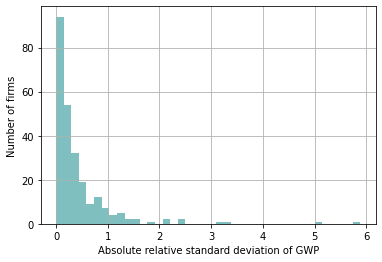

In [5]:
# Plot a histogram of the absolute relative standard deviations:
rel_std = abs(std_GWP / mean_GWP)
hist = rel_std.hist(bins=40, color='teal', alpha=0.5)
hist.set_xlabel('Absolute relative standard deviation of GWP')
hist.set_ylabel('Number of firms')

From the above histogram, some firms show excessively large variation in their relative turnover. On the other hand, most firms exhibit low variation. Because of the assumed scarcity of available resources, lets say the threshold above which a particular firm should be investigated further is 1. We can take this filtering further by identifying the firms which are also high earners (GWP > 1 billion).

Highly voltatile and high earning firms: ['Firm 104' 'Firm 131' 'Firm 26']


Text(0, 0.5, 'GWP')

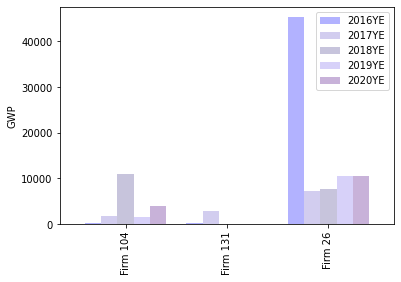

In [6]:
high_variance_firms = np.array(rel_std[rel_std > 1].index)
high_earner_firms = np.array(mean_GWP[mean_GWP > 1000].index)
ff = np.intersect1d(high_variance_firms, high_earner_firms) # Firms to look at
print('Highly voltatile and high earning firms: {}'.format(ff))

bar = data_s0['GWP (£m)'].loc[ff].plot.bar(color=['blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'indigo'],
                                           alpha=0.3, width=0.8)
bar.set_ylabel('GWP')

The mean GWP does not seem to vary much from year-to-year, though the variance bewteen different firms each year is large, as seen below.

Text(0.5, 1.0, 'Firms above 10 million')

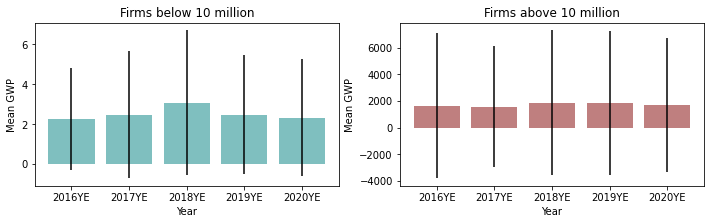

In [9]:
yearly_mean_GWP_below_10m = data_s0['GWP (£m)'][(data_s0['GWP (£m)'] < 10) & (data_s0['GWP (£m)'] > -10)].replace(0, np.NaN).mean(axis=0)
yearly_std_GWP_below_10m = data_s0['GWP (£m)'][(data_s0['GWP (£m)'] < 10) & (data_s0['GWP (£m)'] > -10)].replace(0, np.NaN).std(axis=0)


yearly_mean_GWP_above_10m = data_s0['GWP (£m)'][data_s0['GWP (£m)'] > 10].replace(0, np.NaN).mean(axis=0)
yearly_std_GWP_above_10m = data_s0['GWP (£m)'][data_s0['GWP (£m)'] > 10].replace(0, np.NaN).std(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12,3))
ax[0].bar(list(yearly_mean_GWP_below_10m.index), np.array(yearly_mean_GWP_below_10m),
          yerr=np.array(yearly_std_GWP_below_10m), color='teal', alpha=0.5)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Mean GWP')
ax[0].set_title('Firms below 10 million')
ax[1].bar(list(yearly_mean_GWP_above_10m.index), np.array(yearly_mean_GWP_above_10m),
          yerr=np.array(yearly_std_GWP_above_10m),  color='maroon', alpha=0.5)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Mean GWP')
ax[1].set_title('Firms above 10 million')

Below I also plot a scatter matrix corresponding to both data sets. Looks like the first set has many highly correlated metrics. The second set- less. These plots are also useful for identifying the presence of outliers in each of the metrics.

In [14]:
idx = pd.IndexSlice
x_2020_s0 = data_s0.loc[:,idx[:,'2020YE']]
x_2020_s1 = data_s1.loc[:,idx[:,'2020YE']]

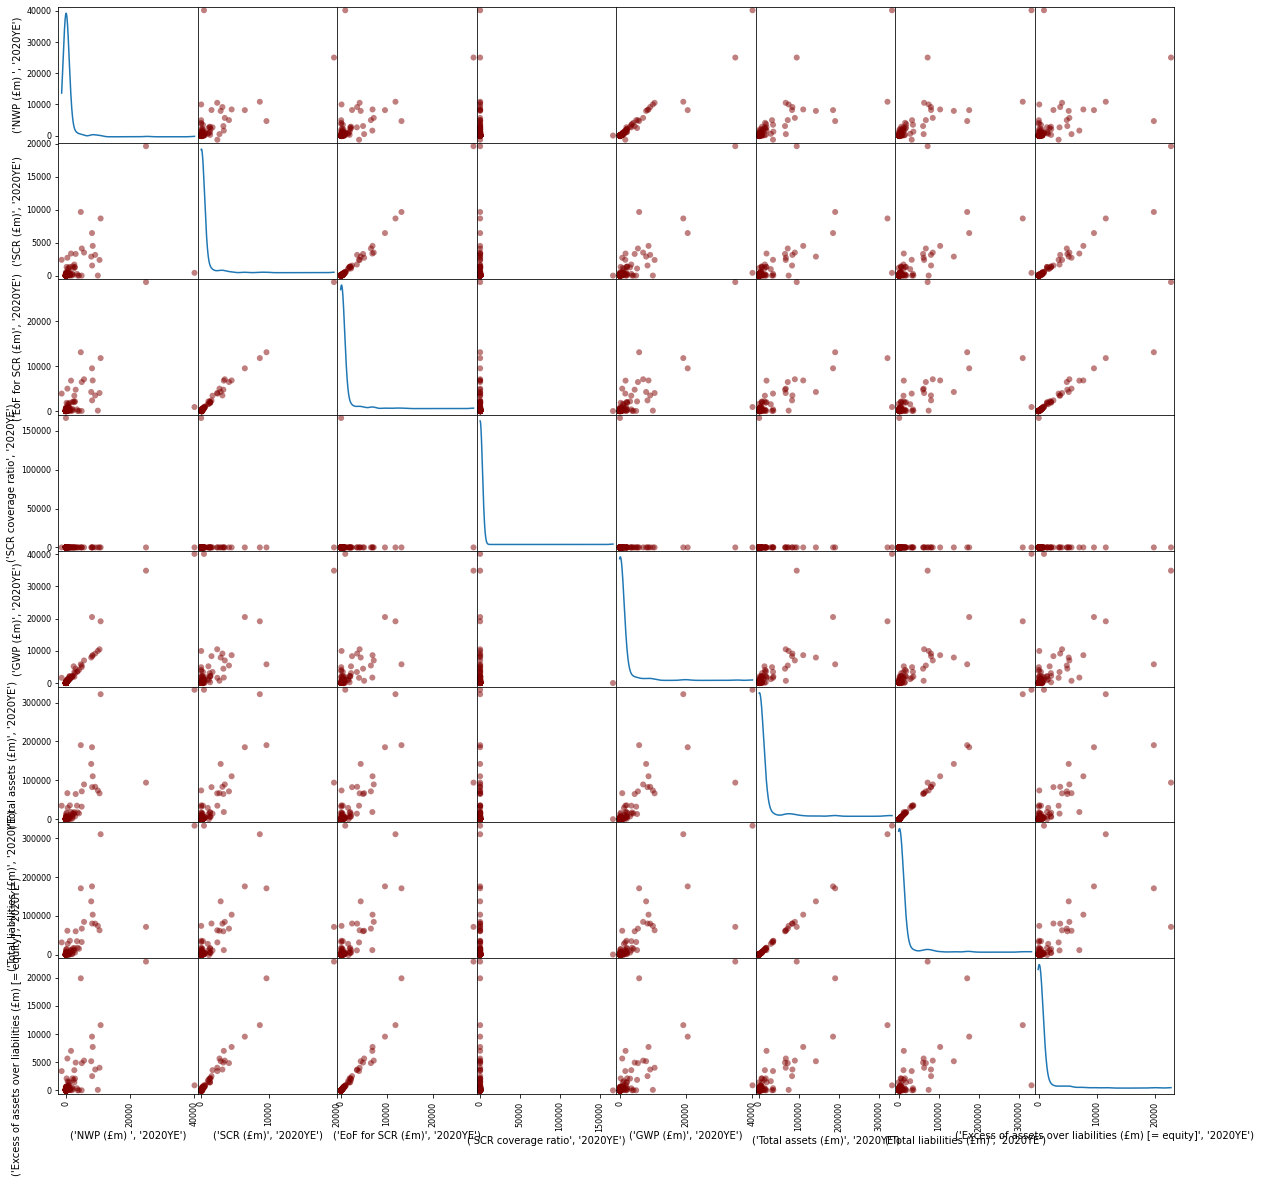

In [15]:
sm = scatter_matrix(x_2020_s0, color='maroon', figsize=(20,20), marker='o', diagonal='kde')

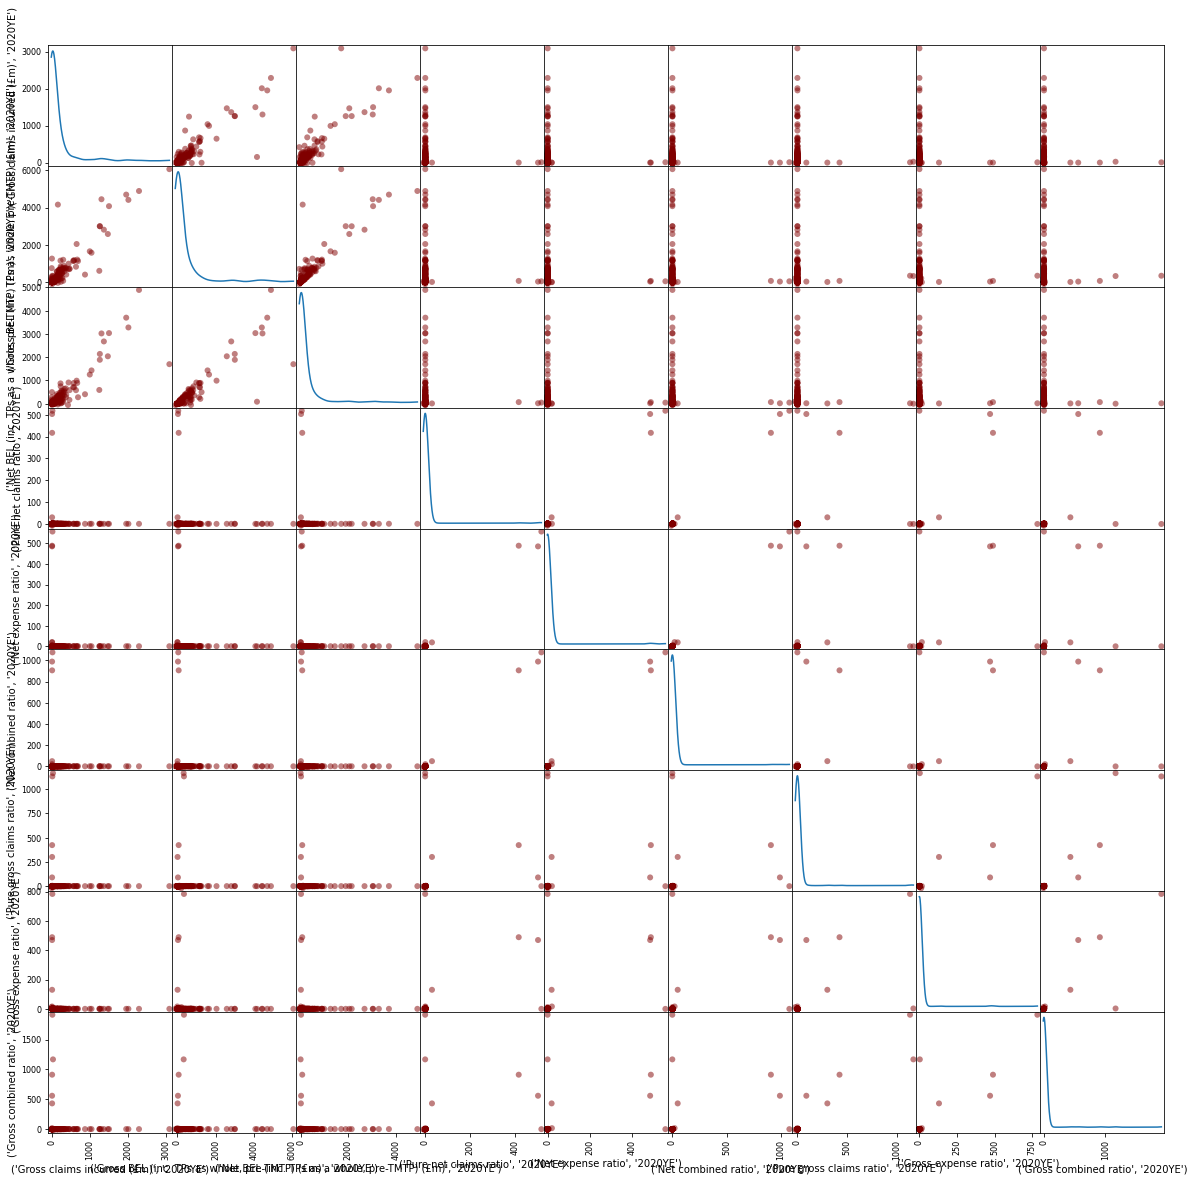

In [16]:
sm = scatter_matrix(x_2020_s1, color='maroon', figsize=(20,20), marker='o', diagonal='kde')

# Net Written Premium

Higher values of net written premium correspond to firms which make a larger profit. Lower values will correspond to firms making a smaller profit and negative values to firms which loose money. Thus a reasonable trend to look at is how NWP changes for two consecutive years. But first, knowing that 2020 was a 'shocker' year, it is interesting to compare the NWP with the year before. Indeed, we see more firms with a negative NWP for the year 2020. On the other hand, the difference between 2019 and 2018 is visibly smaller, indicating some consistency through regular years.

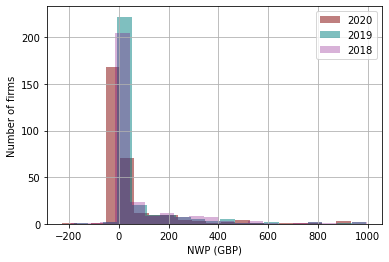

In [17]:
NWP_2018 = data_s0['NWP (£m) ']['2018YE']
NWP_2019 = data_s0['NWP (£m) ']['2019YE']
NWP_2020 = data_s0['NWP (£m) ']['2020YE']

hist = NWP_2020[(NWP_2020 < 1000) & (NWP_2020 > -500)].hist(bins=20, color='maroon', alpha=0.5, label='2020')
hist = NWP_2019[(NWP_2019 < 1000) & (NWP_2019 > -500)].hist(bins=20, color='teal', alpha=0.5, label='2019')
hist = NWP_2018[(NWP_2018 < 1000) & (NWP_2018 > -500)].hist(bins=20, color='purple', alpha=0.3, label='2018')
hist.set_xlabel('NWP (GBP)')
hist.set_ylabel('Number of firms')
hist.legend()

I choose here the years 2020 and 2019 and find by how much NWP changes in the year 2020 relative to the year 2019. Then I identify the firms which experienced a negative change. All NaN and infinite values correspond to firms which do not have this information available.

Text(0, 0.5, 'Number of firms')

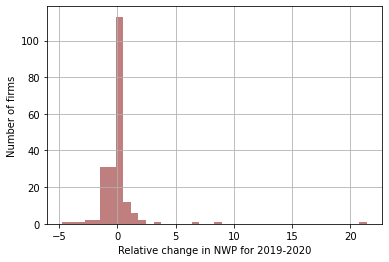

In [18]:
NWP_change = (NWP_2020 - NWP_2019) / NWP_2019
NWP_change = NWP_change.replace([np.inf, -np.inf], np.nan)

hist = NWP_change[NWP_change > -20].hist(bins=40, color='maroon', alpha=0.5)
hist.set_xlabel('Relative change in NWP for 2019-2020')
hist.set_ylabel('Number of firms')

In [19]:
negative_NWP_firms = np.array(NWP_change[NWP_change < -1].index)
print('Firms which experienced a negative change in NWP: {}'.format(negative_NWP_firms))

Firms which experienced a negative change in NWP: ['Firm 34' 'Firm 53' 'Firm 55' 'Firm 61' 'Firm 152' 'Firm 188' 'Firm 230'
 'Firm 245' 'Firm 274' 'Firm 313' 'Firm 316' 'Firm 321']


# SCR coverage ratio

I find that most firms have an SCR below 10 %. For the years 2019 and 2020 I idenified two firms which have unusually high SCR.

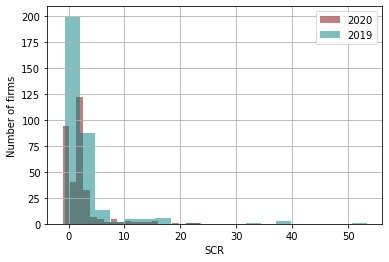

In [20]:
SCR_2020 = data_s0['SCR coverage ratio']['2020YE']
SCR_2019 = data_s0['SCR coverage ratio']['2019YE']
hist = SCR_2020[SCR_2020 < 100].hist(bins=20, color='maroon', alpha=0.5, label='2020')
hist = SCR_2019[SCR_2019 < 100].hist(bins=20, color='teal', alpha=0.5, label='2019')
hist.set_xlabel('SCR')
hist.set_ylabel('Number of firms')
hist.legend()

In [21]:
print('{} has an exceedingly large SCR for the year 2020'.format(SCR_2020[SCR_2020 > 100].index[0]))

Firm 127 has an exceedingly large SCR for the year 2020


In [22]:
print('{} have an exceedingly large SCR for the year 2019'.format(np.array(SCR_2019[SCR_2019 > 100].index)))

['Firm 127' 'Firm 291'] have an exceedingly large SCR for the year 2019


# Gross claims incurred

According to my undestanding, the higher the gross claim incurred, the larger the expenses for an insurance company. Thus any increasing trend should be justified by an increase in, for example, the net written premium (NWP). I fit a linear model for the GCI for each firm as a function of the year it was recorded and compute the explained variance, $R^{2}$. From this analysis I exclude firms which have missing values for the GCI for the years 2019 and 2020.

I then find firms which have a significant increase in the gross claims incurred but have a decrease in their NWP.

In [23]:
GCI = data_s1['Gross claims incurred (£m)']
NWP = data_s0['NWP (£m) ']

In [24]:
GCI_mod = GCI[(GCI['2019YE'] != 0) & (GCI['2020YE'] != 0)]
NWP_mod = NWP[(GCI['2019YE'] != 0) & (GCI['2020YE'] != 0)]
firms = np.array(GCI_mod.index)

In [25]:
years = np.arange(1, 6, 1)
coef_container_GCI = []
r2_container_GCI = []
coef_container_NWP = []
r2_container_NWP = []
for firm_GCI, firm_NWP in zip(np.array(GCI_mod), np.array(NWP_mod)):
    reg = LinearRegression().fit(years.reshape(-1, 1), firm_GCI.reshape(-1, 1))
    y_pred = reg.predict(years.reshape(-1, 1))
    r2 = r2_score(firm_GCI, y_pred)
    coef_container_GCI.append(reg.coef_[0, 0])
    r2_container_GCI.append(r2)
    
    reg = LinearRegression().fit(years.reshape(-1, 1), firm_NWP.reshape(-1, 1))
    y_pred = reg.predict(years.reshape(-1, 1))
    r2 = r2_score(firm_NWP, y_pred)
    coef_container_NWP.append(reg.coef_[0, 0])
    r2_container_NWP.append(r2)
coef_container_GCI, r2_container_GCI = np.array(coef_container_GCI), np.array(r2_container_GCI)
coef_container_NWP, r2_container_NWP = np.array(coef_container_NWP), np.array(r2_container_NWP)

array = np.c_[coef_container_GCI, r2_container_GCI]
GCI_coefficients = pd.DataFrame(data = array, 
                                index = firms, 
                                columns = ['Coefficient', 'R squared'])

array = np.c_[coef_container_NWP, r2_container_NWP]
NWP_coefficients = pd.DataFrame(data = array, 
                                index = firms, 
                                columns = ['Coefficient', 'R squared'])

In [26]:
high_increase_GCI_firms = GCI_coefficients[(GCI_coefficients['R squared'] > 0.6) & (GCI_coefficients['Coefficient'] > 0.0)].index
high_increase_NWP_firms = GCI_coefficients[(NWP_coefficients['R squared'] > 0.6) & (NWP_coefficients['Coefficient'] < 0.0)].index

GCI_alert_firms = np.intersect1d(np.array(high_increase_GCI_firms), np.array(high_increase_NWP_firms))

print('Firms with an increasing GCI but a decreasing NWP {}'.format(GCI_alert_firms))

Firms with an increasing GCI but a decreasing NWP ['Firm 14' 'Firm 154' 'Firm 194' 'Firm 267' 'Firm 268' 'Firm 36' 'Firm 40'
 'Firm 46' 'Firm 91']


And this is how the GCI and NWP varied for these firms:

Text(0, 0.5, 'NWP')

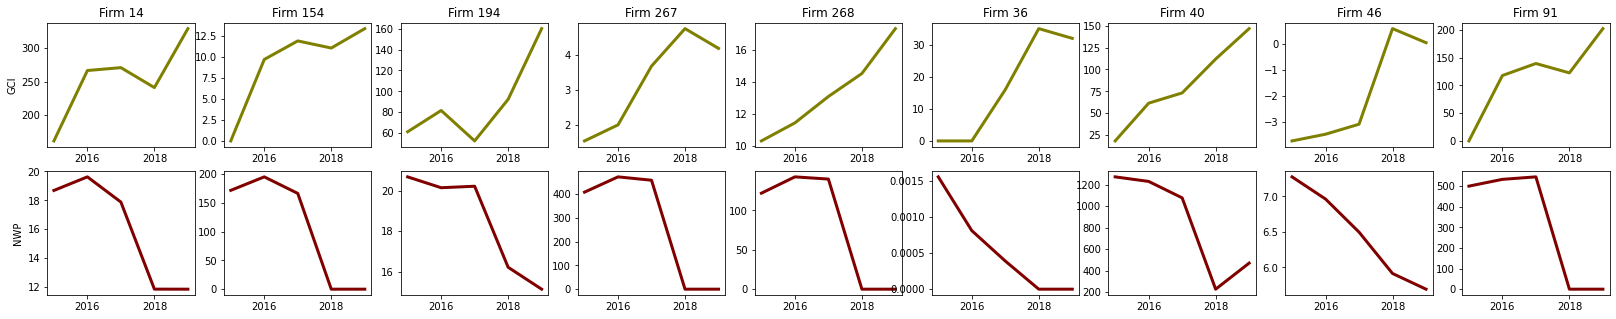

In [37]:
n = len(GCI_alert_firms)
i = 0
fig, ax = plt.subplots(2, n, figsize=(28,5))
for firm in GCI_alert_firms:
    ax[0][i].plot(years + 2014, GCI_mod.loc[firm], linewidth=3.0, color='olive')
    ax[0][i].set_title(firm)
    ax[1][i].plot(years + 2014, NWP_mod.loc[firm], linewidth=3.0, color='maroon')
    i += 1
ax[0][0].set_ylabel('GCI')
ax[1][0].set_ylabel('NWP')

# Net Combined Ratio

This to me seems like the most important feature. It defines whether a particular firm makes a profit and thus evaluates its risks in an adequate manner. Most firms exhibit a small net combined ratio. Not sure if negative values make sense.

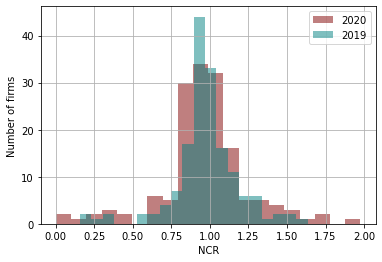

In [28]:
NCR_2020 =  data_s1['Net combined ratio']['2020YE']
NCR_2019 =  data_s1['Net combined ratio']['2019YE']
hist = NCR_2020[(NCR_2020 < 2) & (NCR_2020 > 0)].hist(bins=20, color='maroon', alpha=0.5, label='2020')
hist = NCR_2019[(NCR_2019 < 2) & (NCR_2019 > 0)].hist(bins=20, color='teal', alpha=0.5, label='2019')
hist.set_xlabel('NCR')
hist.set_ylabel('Number of firms')
hist.legend()

In [29]:
# Unprofitable firms:
NCR_2020[NCR_2020 > 100]

Firm 166     989.155405
Firm 228    1076.158703
Firm 284     906.307872
Name: 2020YE, dtype: float64

In [30]:
# Firms with negative net combined ratio- probably do not make sense:
NCR_2020[NCR_2020 < 0]

Firm 4     -3.408470
Firm 209   -0.200397
Firm 251   -9.490844
Firm 308   -1.606940
Name: 2020YE, dtype: float64

# Random forest regressors for predicting future net combined ratios

Here I build a random forest regression model to predict the net combined ratios for a future year. As an example, I use data from the year 2018 to predict the net combined ratios for 2019.

I choose to model NCR values in the range 0-2.

Text(0.5, 1.0, 'NCR in range 0-2')

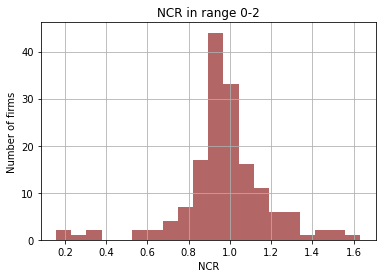

In [31]:
hist = NCR_2019[(NCR_2019 < 2) & (NCR_2019 > 0)].hist(bins=20, color='maroon', alpha=0.6)
hist.set_xlabel('NCR')
hist.set_ylabel('Number of firms')
hist.set_title('NCR in range 0-2')

In [32]:
# Select firms which have available information across all metrics for the years 2016-2018:
#combined_data = pd.concat([data_s0, data_s1], axis=1, join="inner")
check_firm_s1 = np.all((data_s1_np[:, :, :3] != 0).reshape(325, 9 * 3) == True, axis=-1)
firms_to_look_at = np.array(data_s1.index[check_firm_s1])

# Select firms with records of the net combined ratio for the year 2019 (this is the target variable):
NCR = data_s1['Net combined ratio']
NCR_2019 = NCR['2019YE']
non_zero_NCR = NCR_2019[NCR_2019 != 0.0]
NCR_look_at = np.array(non_zero_NCR[(non_zero_NCR < 2) & (non_zero_NCR > 0)].index)

# Now get the firms that match both of the above criteria:
target_firms = np.intersect1d(firms_to_look_at, NCR_look_at)

In [33]:
idx = pd.IndexSlice
x_2018 = data_s1.loc[target_firms,idx[:,'2018YE']].drop('Net combined ratio', axis=1)
y_2019 = NCR_2019.loc[target_firms]

C:\Users\sjurg\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [34]:
# Split data into training and test sets:
(X_2018_train,
 X_2018_test,
 y_2019_train,
 y_2019_test) = train_test_split(x_2018, y_2019, test_size=0.15, random_state=1)

In [35]:
# Fit the random forest regressor:
regr_2018 = RandomForestRegressor(n_estimators=500, 
                            max_features=3)
regr_2018.fit(np.array(X_2018_train), y_2019_train);

The test RMSE for the year 2016 is 0.14553264966507257
Mean fractional error for the test predictions is 8.3 %


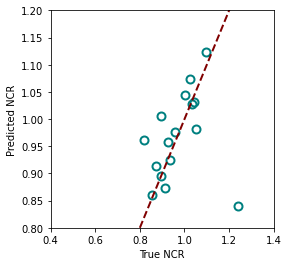

In [36]:
predictions = regr_2018.predict(np.array(X_2018_test))
rmse = np.sqrt(mean_squared_error(y_2019_test, predictions))

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(y_2019_test, predictions, linestyle='', color='teal', marker='o', fillstyle='none', markersize=8, markeredgewidth=2.0)
ax.plot(np.arange(0.4,2,0.2), np.arange(0.4,2,0.2), color='maroon', linestyle='--', linewidth=2.0)
ax.set_xlabel('True NCR')
ax.set_ylabel('Predicted NCR')
ax.set_xlim([0.4,1.4])
ax.set_ylim([0.8,1.2])

mean_f_e = np.abs((y_2019_test - predictions) / y_2019_test).mean() * 100

print('The test RMSE for the year 2016 is {}'.format(rmse))
print('Mean fractional error for the test predictions is {} %'.format(round(mean_f_e, 1)))

Because most values of NCR in the used data set are clustered around ~0.9, the model works best for those values. Values which deviate substantially from 0.9 are scarce so the model does not generalize well for these values.